In [1]:
import pint.toa
import pint.models
import pint.fitter
import pint.residuals
import pint.utils
import pint.models.model_builder as mb
import pint.random_models
from pint.phase import Phase
from copy import deepcopy
from collections import OrderedDict
#from astropy import log
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import operator
import time
from pathlib import Path
#import APT_argparse
import socket

In [ ]:
def JUMP_adder_begginning(
    mask: np.ndarray, toas, model, output_parfile, output_timfile
):
    """
    Adds JUMPs to a timfile as the begginning of analysis.

    Parameters
    ----------
    mask : a mask to select which toas will not be jumped
    toas : TOA object
    output_timfile : name for the tim file to be written
    output_parfile : name for par file to be written

    Returns
    -------
    model, t
    """
    t = deepcopy(toas)
    flag_name = "jump_tim"

    former_cluster = t.table[mask]["clusters"][0]
    j = 0
    for i, table in enumerate(t.table[~mask]):
        if table["clusters"] != former_cluster:
            former_cluster = table["clusters"]
            j += 1
        table["flags"][flag_name] = str(j)
    t.write_TOA_file(output_timfile)

    # model.jump_flags_to_params(t) doesn't currently work (need flag name to be "tim_jump" and even then it still won't work),
    # so the following is a workaround. This is likely related to issue 1294.
    ### (workaround surrounded in ###)
    with open(output_parfile, "w") as parfile:
        parfile.write(model.as_parfile())
        for i in range(1, j + 1):
            parfile.write(f"JUMP\t\t-{flag_name} {i}\t0 1 0\n")
    model = mb.get_model(output_parfile)
    ###

    return model, t

In [43]:
f = pint.fitter.WLSFitter(t, m)

f.get_designmatrix()

array([   0.40726644, -215.77663308])

In [85]:
from APT_binary import JUMP_adder_begginning, starting_points
os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary3_1")
#os.chdir("/users/jdtaylor/Jackson/APT/binary3_4")

parfile = Path("fake_1.par")
timfile = Path("fake_1.tim")
m, t = mb.get_model_and_toas(parfile, timfile)
t.table["clusters"] = t.get_clusters()
masks = starting_points(toas = t)[0]
mask = masks[0]
t, m = JUMP_adder_begginning(mask, t, m, "start.tim", "start.par")
t.table['flags']
type(m)

2022-06-24 14:38:49.660 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-24 14:38:49.662 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-24 14:38:49.679 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-24 14:38:49.681 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-24 14:38:49.683 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-24 14:38:49.793 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-24 14:38:49.794 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-24 14:38:49.795 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

pint.models.timing_model.TimingModel

In [3]:
m.as_parfile() # adding jumps natively gives errors so I will add them manually
with open("thisisatest1.par", "w") as parfile:
    parfile.write(m.as_parfile())
    for i in range(1, 31):
        parfile.write(f"JUMP\t\t-jump_tim {i}\t0 1 0\n")
    

In [13]:
from APT_binary import JUMP_adder_begginning, starting_points
os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary3_1")

parfile = Path("fake_1.par")
timfile = Path("fake_1.tim")
m, t = mb.get_model_and_toas(parfile, timfile)
t.table["clusters"] = t.get_clusters()
mask, clusters = starting_points(toas = t)
t, m = JUMP_adder_begginning(mask[0], t, m, "thisisatest.tim", "thisisatest.par")

2022-06-23 15:29:14.901 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-23 15:29:14.902 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-23 15:29:14.919 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-23 15:29:14.920 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-23 15:29:14.922 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-23 15:29:15.008 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-23 15:29:15.009 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-23 15:29:15.010 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

In [3]:
m.components

{'AbsPhase': AbsPhase(
     MJDParameter(   TZRMJD              56000.0000000000000000 (d) frozen=True),
     strParameter(   TZRSITE             GBT               frozen=True),
     floatParameter( TZRFRQ              1400.0            (MHz) frozen=True)),
 'Spindown': Spindown(
     floatParameter( F0                  2.4553950186475038 (Hz) +/- 1e-06 Hz frozen=False),
     MJDParameter(   PEPOCH              56000.0000000000000000 (d) frozen=True),
     floatParameter( F1                  0.0               (Hz / s) +/- 0.0 Hz / s frozen=True)),
 'PhaseJump': PhaseJump(
     maskParameter(JUMP1 -jump_tim 1 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP2 -jump_tim 2 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP3 -jump_tim 3 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP4 -jump_tim 4 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP5 -jump_tim 5 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP6 -jump_tim 6 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP7 -jump_tim 7 0.0 +/- 0.0 s (s)),
     maskParameter(JUM

In [36]:
# Now to test out the design matrix

m1 = deepcopy(m)
t1 = deepcopy(t)

f1 = pint.fitter.WLSFitter(t1, m1)
# f = pint.fitter.WLSFitter(t, m)
# f.get_designmatrix()
m1.components

AttributeError: Attribute JUMP not found in TimingModel or any Component

In [60]:
def JUMP_adder_begginning_cluster(
    mask: np.ndarray, toas, model, output_timfile, output_parfile
):
    """
    Adds JUMPs to a timfile as the begginning of analysis.

    mask : a mask to select which toas will not be jumped
    toas : TOA object
    output_timfile : name for the tim file to be written
    output_parfile : name for par file to be written
    """
    t = deepcopy(toas)
    flag_name = "tim_jump"

    former_cluster = t.table[mask]["clusters"][0]
    j = 0
    for i, table in enumerate(t.table[~mask]):
        # if table["clusters"] != former_cluster:
        #     former_cluster = table["clusters"]
        #     j += 1
        table["flags"][flag_name] = str(table["clusters"])
    t.write_TOA_file(output_timfile)

    # model.jump_flags_to_params(t) doesn't currently work (need flag name to be "tim_jump" and even then it still won't work),
    # so the following is a workaround. This is likely related to issue 1294.
    ### (workaround surrounded in ###)
    # with open(output_parfile, "w") as parfile:
    #     parfile.write(model.as_parfile())
    #     for i in set(t.table[~mask]["clusters"]):
    #         parfile.write(f"JUMP\t\t-{flag_name} {i}\t0 1 0\n")
    # model = mb.get_model(output_parfile)
    ###

    return t, model

#os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary3_1")
os.chdir(Path("/users/jdtaylor/Jackson/APT/binary_test_data/binary4_100"))

parfile = Path("fake_100.par")
timfile = Path("fake_100.tim")
m, t = mb.get_model_and_toas(parfile, timfile)
t.table["clusters"] = t.get_clusters()
masks, clusters = starting_points(toas = t)
mask = masks[0]
t, m = JUMP_adder_begginning_cluster(mask, t, m, "start.tim", "start.par")

2022-06-24 11:25:43.132 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-24 11:25:43.139 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-24 11:25:43.155 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-24 11:25:43.158 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-24 11:25:43.160 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-24 11:25:43.238 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-24 11:25:43.239 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-24 11:25:43.240 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

In [75]:
# Now to test out the design matrix
f = pint.fitter.WLSFitter(t, m)
m1 = deepcopy(m)
t1 = deepcopy(t)

f1 = pint.fitter.WLSFitter(t1, m1)
# f = pint.fitter.WLSFitter(t, m)
# f.get_designmatrix()

#print(f1.model.as_parfile())
#print(pint.residuals.Residuals(t, f1.model).chi2_reduced)
print(f1.get_designmatrix())
f1.fit_toas()
print("#"*100)
print(f1.get_designmatrix())
#print(pint.residuals.Residuals(t, f1.model).chi2_reduced)
#print(f1.model.as_parfile())


2022-06-23 16:16:31.503 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-06-23 16:16:31.507 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-23 16:16:31.508 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-23 16:16:31.510 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-23 16:16:31.511 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-23 16:16:31.512 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-23 16:16:31.515 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-23 16:16:31.515 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculat

(array([[ 4.07266445e-01, -2.15776633e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07266445e-01, -4.17804368e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07266445e-01, -6.19666176e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [ 4.07266445e-01, -2.20250723e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07266445e-01, -2.20252741e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07266445e-01, -2.20254762e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00]]), ['Offset', 'F0', 'JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JU

2022-06-23 16:16:32.038 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:110 - Done with TZR_toa


####################################################################################################
(array([[ 4.07263201e-01, -2.15774914e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07263201e-01, -4.17801040e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 4.07263201e-01, -6.19661240e+02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [ 4.07263201e-01, -2.20248968e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07263201e-01, -2.20250987e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00],
       [ 4.07263201e-01, -2.20253007e+07, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.00000000e+00]]), ['Offset', 'F0', 'JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'J

In [79]:
print(len(f1.get_designmatrix()[0]))
print(len(f1.get_designmatrix()[0][0]))
print(f1.get_designmatrix()[0][0])
print(f.get_designmatrix()[0][0])
print(f.get_designmatrix()[1])

149
32
[   0.4072632 -215.7749143   -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.          -0.          -0.          -0.
   -0.          -0.       ]
[   0.40726644 -215.77663308   -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.           -0.        ]
['Offset', 'F0', 'JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP

In [67]:
os.chdir(Path("/users/jdtaylor/Jackson/APT/binary_test_data/binary4_100"))

parfile = "fake_100edit.par"
timfile = "fake_100.timJUMP"
m, t = pint.models.get_model_and_toas(parfile, timfile)

x = t.get_mjds().value
resid = pint.residuals.Residuals(t, m).calc_phase_resids()

# fig, ax = plt.subplots(1,1,figsize=(15,10))
# ax.plot(x, resid, "o")

t.get_clusters() == 5
type(t)

2022-06-24 14:29:31.391 | DEBUG    | pint.toa:__init__:1304 - No pulse number flags found in the TOAs
2022-06-24 14:29:31.393 | DEBUG    | pint.toa:apply_clock_corrections:2085 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-06-24 14:29:31.408 | INFO     | pint.observatory.topo_obs:clock_corrections:258 - Applying observatory clock corrections.
2022-06-24 14:29:31.410 | INFO     | pint.observatory.topo_obs:clock_corrections:263 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-06-24 14:29:31.412 | INFO     | pint.observatory.topo_obs:clock_corrections:268 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-06-24 14:29:31.493 | DEBUG    | pint.toa:compute_TDBs:2148 - Computing TDB columns.
2022-06-24 14:29:31.494 | WARNING  | pint.toa:compute_TDBs:2160 - No ephemeris provided to TOAs object or compute_TDBs. Using DE421
2022-06-24 14:29:31.495 | DEBUG    | pint.toa:compute_TDBs:2173 - Using EPHEM = DE421 for TDB calculation.
2022-06-

pint.toa.TOAs

In [52]:
import pint.models as pm
if socket.gethostname()[0] == "J":
    os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary4_100")
else:
    os.chdir("/users/jdtaylor/Jackson/APT/binary_test_data/binary4_100")
m1, t1 = pm.get_model_and_toas("fake_100sol.par", "fake_100.tim")
# t1.compute_pulse_numbers(m1)
# pn1 = t1.table["pulse_number"]

# m2, t2 = pm.get_model_and_toas("solved_100.par", "fake_100.tim")
# t2.compute_pulse_numbers(m2)
# pn2 = t2.table["pulse_number"]



In [76]:
# t3 = deepcopy(t2)
# dpn = pn2 - pn1
# t3.table["delta_pulse_number"] = dpn
# pn3 = t3.table["pulse_number"]
x = np.array([1,2,3])
y = np.array([1,2])
np.concatenate((x,y))

array([1, 2, 3, 1, 2])

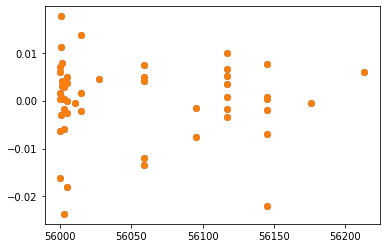

In [58]:
y3 = pint.residuals.Residuals(t3, m1).calc_phase_resids()
y1 = pint.residuals.Residuals(t1, m1).calc_phase_resids()
x1 = t1.get_mjds().value
x3 = t3.get_mjds().value

plt.plot(x3, y3, 'o')
plt.plot(x1, y1, 'o')

In [59]:
t3.table["pulse_number"] - t1.table["pulse_number"] 

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [56]:
"mjd" in t1.table.columns

True

In [8]:
#residuals = np.array([1,2,3,4,2])
residuals = np.array([0.24963299, 0.30871647, 0.37203439, 0.44167943, 0.50239736, -0.43294805])
mjds = np.array([56054.33430246, 56054.34040344, 56054.34650443, 56054.35260039,
       56054.35870137, 56054.36480237])
residualsdif_dif = np.concatenate(
    (np.zeros(1), residuals)
) - np.concatenate((residuals, np.zeros(1)))
mjds_dif = np.concatenate((np.zeros(1), mjds)) - np.concatenate(
    (mjds, np.zeros(1))
)
toa_slopes = (residualsdif_dif / mjds_dif)[1:-1]
print(toa_slopes)
print(toa_slopes > 0)
# want to establish the correct slope direction as that with the longest
# series of adjacent slopes
biggest = 0
location_of_biggest = -1
biggest_is_pos = True
was_pos = True
count = 0
for i, is_pos in enumerate(toa_slopes >= 0):
    if is_pos and was_pos or (not is_pos and not was_pos):
        count += 1
        print(f"{i}: {count}")
        was_pos = is_pos
    elif is_pos or was_pos:
        print("flipped")
        if count > biggest:
            biggest = count
            location_of_biggest = i - 1
            biggest_is_pos = is_pos
        count = 1
        was_pos = is_pos
    # do this check one last time in case the last point is part of the
    # longest series of adjacent slopes
    if count > biggest:
            biggest = count
            location_of_biggest = i # not i - 1 because that last point is like the (i + 1)th element
                                    # flipping slopes
            biggest_is_pos = is_pos

print(f"biggest is {biggest}. location of biggest is {location_of_biggest}")
print(toa_slopes[location_of_biggest-biggest+1:location_of_biggest+1])
print()
print(residuals[:location_of_biggest-biggest+1])
print(residuals[location_of_biggest+2:])




[   9.68426057   10.37830253   11.42478626    9.95216014 -153.31018032]
[ True  True  True  True False]
0: 1
1: 2
2: 3
3: 4
flipped
biggest is 4. location of biggest is 3
[ 9.68426057 10.37830253 11.42478626  9.95216014]

[]
[-0.43294805]


In [2]:
import pint.logging
pint.logging.setup(level = "ERROR")

1

cluster 9
that took 0.002881623000007494 seconds


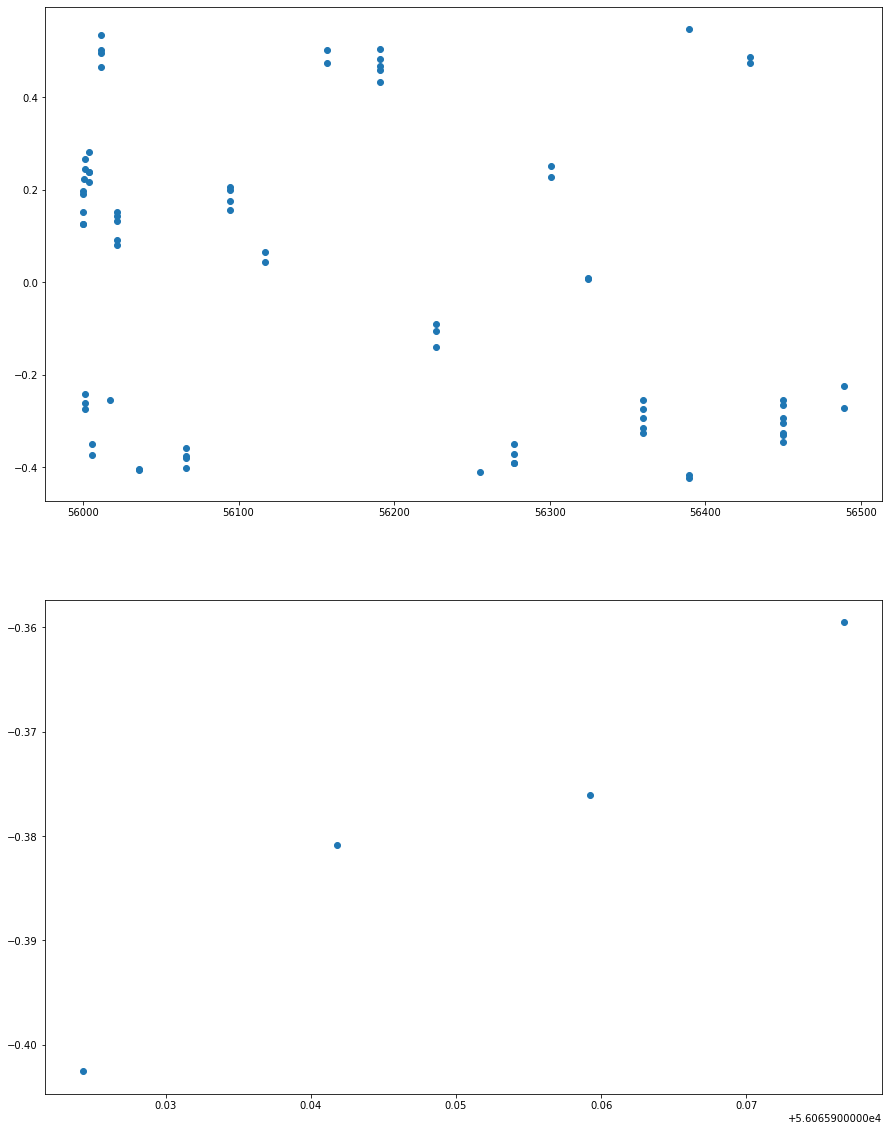

In [2]:
import pint.logging, socket, numpy as np, matplotlib.pyplot as plt, time
from copy import deepcopy
pint.logging.setup(level = "ERROR")

import pint.models as pm
from APT_binary import phase_connector
data_path = "binary6_1"
if socket.gethostname()[0] == "J":
    os.chdir(f"/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/{data_path}")
else:
    os.chdir(f"/users/jdtaylor/Jackson/APT/binary_test_data/{data_path}")
m, t = pm.get_model_and_toas(f"fake_{data_path.split('_')[-1]}.par", f"fake_{data_path.split('_')[-1]}.tim")
if "clusters" not in t.table.columns:
        t.table["clusters"] = t.get_clusters()
if "pulse_number" not in t.table.colnames:
    t.compute_pulse_numbers(m)

y = pint.residuals.Residuals(t, m).calc_phase_resids()
#y1 = pint.residuals.Residuals(t1, m1).calc_phase_resids()
x = t.get_mjds().value

# cluster= 0
# cluster_mask1 = t.table["clusters"] == 0
# cluster_mask2 = t.table["clusters"] == 1
# cluster_mask = np.zeros(len(t.table), dtype=bool)
cluster_mask = t.table["clusters"] == 9
# for i in range(len(cluster_mask1)):
#     if cluster_mask1[i] or cluster_mask2[i]:
#         cluster_mask[i] = True
#t_copy = deepcopy(t)
#t.select(cluster_mask)
t1 = time.monotonic()
phase_connector(t, m, "linear", cluster = 9, wraps = True, mjds_total=x, residuals_total=y)
t2 = time.monotonic()
print(f"that took {t2 - t1} seconds")

# t1 = time.monotonic()
# phase_connector(t, m, "linear", cluster = "all", wraps = True)
# t2 = time.monotonic()
# print(f"that took {t2 - t1} seconds")
# x1 = x[cluster_mask]
# y1 = y[cluster_mask]
#t.table["delta_pulse_number"][-1] = 0
#t_copy.table[cluster_mask] = t.table
x1 = t.get_mjds().value
x1 = x1[cluster_mask]
y1 = pint.residuals.Residuals(t, m).calc_phase_resids()
y1 = y1[cluster_mask]

fig, ax = plt.subplots(2, figsize = (15,20))
ax[0].plot(x, y, 'o')
ax[1].plot(x1, y1, 'o')


# t.compute_pulse_numbers(m)
# t.write_TOA_file("zzz.tim")

In [7]:
mask = np.zeros(len(t_copy), dtype=bool)
mask[0:2] = True
t_copy.table
t=deepcopy(t_copy)
t.select(mask)
t.table["delta_pulse_number"][0:2] = 1
t_copy.table[mask] = t.table


NameError: name 't_copy' is not defined

In [27]:
print(t.table[6]["pulse_number"])
print(t.table[6]["delta_pulse_number"])
print()

t.compute_pulse_numbers(m)
print(t.table[6]["pulse_number"])
print(t.table[6]["delta_pulse_number"])
print()

t.table[6]["delta_pulse_number"] = -2
resid = pint.residuals.Residuals(t, m).calc_phase_resids()
t.compute_pulse_numbers(m)
print(t.table[6]["pulse_number"])
print(t.table[6]["delta_pulse_number"])

82045.0
-1.0

82044.0
-1.0

82043.0
-2.0


In [1]:
y1


NameError: name 'y1' is not defined

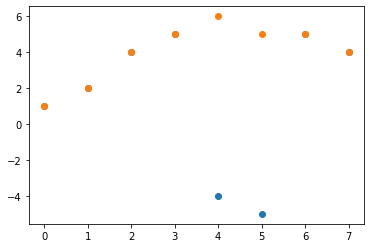

In [5]:
import numpy as np, matplotlib.pyplot as plt
x = np.array([1,2,4,5,-4,-5,5,4])
x1 = np.unwrap(x, period = 10)
plt.plot(np.arange(len(x)), x, "o")
plt.plot(np.arange(len(x1)), x1, "o")

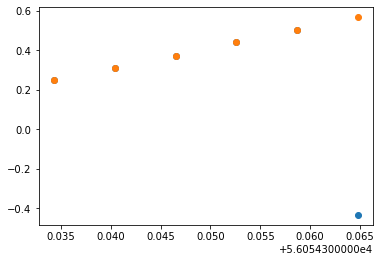

In [10]:
residuals = np.array([0.24963299, 0.30871647, 0.37203439, 0.44167943, 0.50239736, -0.43294805])
mjds = np.array([56054.33430246, 56054.34040344, 56054.34650443, 56054.35260039,
       56054.35870137, 56054.36480237])

residuals_unwrapped = np.unwrap(residuals, period = 1)
plt.plot(mjds, residuals, "o")
plt.plot(mjds, residuals_unwrapped, 'o')

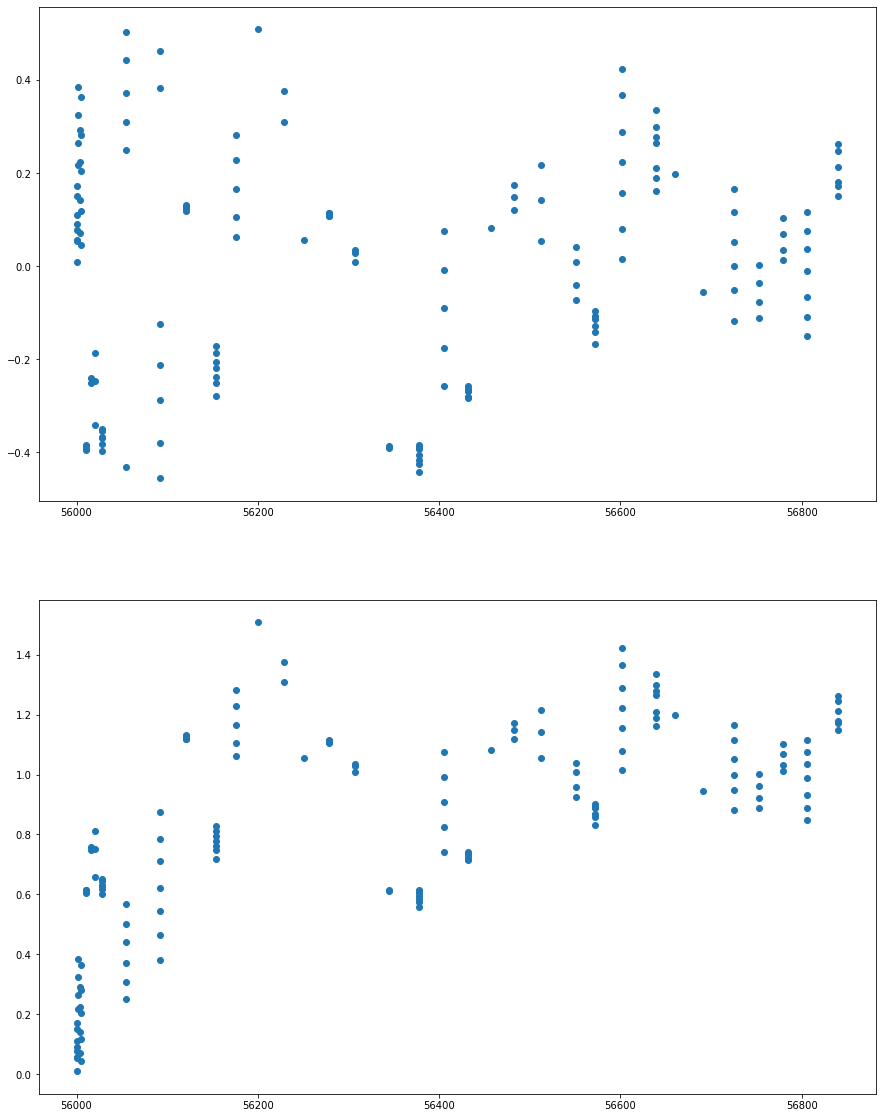

In [16]:
import pint.logging, socket, numpy as np, matplotlib.pyplot as plt, time
from copy import deepcopy
pint.logging.setup(level = "ERROR")

import pint.models as pm
from APT_binary import phase_connector
data_path = "binary4_100"
if socket.gethostname()[0] == "J":
    os.chdir(f"/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/{data_path}")
else:
    os.chdir(f"/users/jdtaylor/Jackson/APT/binary_test_data/{data_path}")
m, t = pm.get_model_and_toas(f"fake_{data_path.split('_')[-1]}.par", f"fake_{data_path.split('_')[-1]}.tim")
if "clusters" not in t.table.columns:
        t.table["clusters"] = t.get_clusters()
if "pulse_number" not in t.table.colnames:
    t.compute_pulse_numbers(m)

y = pint.residuals.Residuals(t, m).calc_phase_resids()
x = t.get_mjds()
y = np.array(y)
fig, ax = plt.subplots(2, figsize = (15,20))
y_unwrapped = np.unwrap(y, period = 1)
ax[0].plot(x, y, 'o')
ax[1].plot(x, y_unwrapped, 'o')

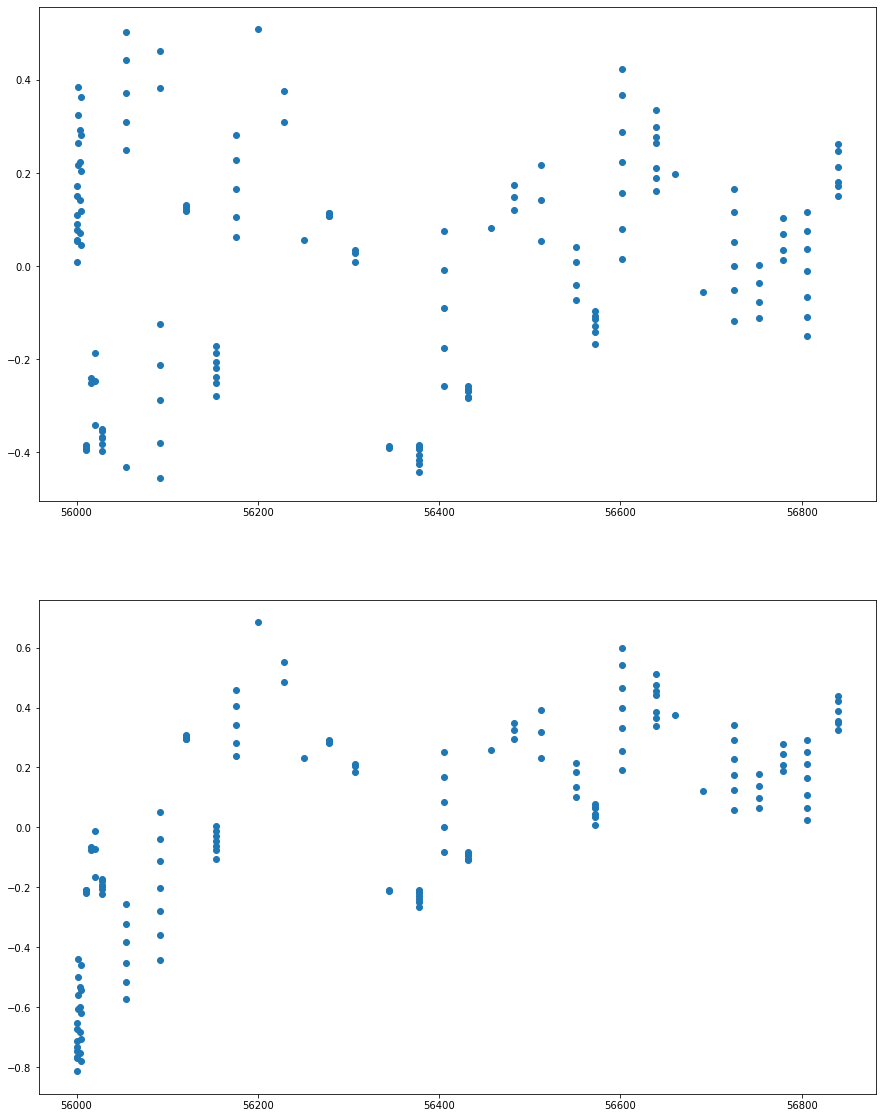

In [20]:
dpn = y_unwrapped - pint.residuals.Residuals(t, m).calc_phase_resids()
t.table["delta_pulse_number"] = dpn
y3 = pint.residuals.Residuals(t, m).calc_phase_resids()

fig, ax = plt.subplots(2, figsize = (15,20))
ax[0].plot(x, y, 'o')
ax[1].plot(x, y3, 'o')


In [9]:
getattr(m, "A1")

floatParameter( A1                  0.030438545804327873 (ls) +/- 0.1 ls frozen=True)

In [36]:
import pint.models.model_builder as mb, matplotlib.pyplot as plt, numpy as np
import pint
from pathlib import Path
pint.logging.setup(level = "ERROR")
os.chdir(Path("/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary6_1"))
m = mb.get_model("fake_1.par")
t = pint.toa.get_TOAs("fake_1.tim")
# getattr(m, "jump_tim 20")
# print(m.as_parfile())
clusters = t.get_clusters()
j = 0
test = [f"JUMP{j:=j+1}" if i != 22+1 else "" for i in range(1, clusters[-1]+2)]
#m.components
test[22]

from APT_binary import phase_connector
t.compute_pulse_numbers(m)
t.table["clusters"] = t.get_clusters()
residuals = pint.residuals.Residuals(t, m).calc_phase_resids()
mjds_total=t.get_mjds().value

fig, ax = plt.subplots(2,1, figsize = (10,15))

ax[0].plot(mjds_total, residuals, 'o')

mask_with_closest = np.logical_or(t.table["clusters"] == 23, t.table["clusters"] == 22)

phase_connector(t, m, "np.unwrap", clusters="all", mjds_total=mjds_total, residuals = residuals, mask_with_closest = mask_with_closest)

residuals = pint.residuals.Residuals(t, m).calc_phase_resids()
ax[1].plot(mjds_total, residuals, 'o')

ValueError: Invalid format specifier

In [82]:
# j = 0
# #print(j:=j+1)
# test = [f"JUMP{(j:=j+1)}" if i != 22 else "" for i in range(clusters[-1]+1)]
# print(test)
# for i,j in enumerate(test):
#     print(i, j)
m = mb.get_model("./alg_saves/fake_1/mask1_cluster0/fake_1_1.par")
getattr(m, "JUMP2").value = 0
getattr(m, "JUMP2").frozen = True
getattr(m, "JUMP2").uncertainty = 0
getattr(m, "JUMP2")

maskParameter(JUMP2 -jump_tim 2 0.0 +/- 0.0 s (s))

In [83]:
for i in range(0):
    print("hi")

In [84]:
m.components

{'AbsPhase': AbsPhase(
     MJDParameter(   TZRMJD              56000.0000000000000000 (d) frozen=True),
     strParameter(   TZRSITE             GBT               frozen=True),
     floatParameter( TZRFRQ              1400.0            (MHz) frozen=True)),
 'Spindown': Spindown(
     floatParameter( F0                  7.3536813633543072466 (Hz) +/- 7.480096906686835e-07 Hz frozen=False),
     MJDParameter(   PEPOCH              56000.0000000000000000 (d) frozen=True),
     floatParameter( F1                  0.0               (Hz / s) +/- 0.0 Hz / s frozen=True)),
 'PhaseJump': PhaseJump(
     maskParameter(JUMP1 -jump_tim 1 0.12759017639708167 +/- 0.012484070555973687 s (s)),
     maskParameter(JUMP2 -jump_tim 2 0.0 +/- 0.0 s (s)),
     maskParameter(JUMP3 -jump_tim 3 0.36552323802824715 +/- 0.02662340729810784 s (s)),
     maskParameter(JUMP4 -jump_tim 4 0.6046937480895088 +/- 0.050719015202058036 s (s)),
     maskParameter(JUMP5 -jump_tim 5 1.4682126918307705 +/- 0.102710967926140

In [91]:
m1, t1 = pint.models.get_model_and_toas("fake_1sol.par", "fake_1.tim")
m2, t2 = pint.models.get_model_and_toas("fake_1.fin", "fake_1.tim")
m3, t3 = pint.models.get_model_and_toas("fake_1.par", "fake_1.tim")

t1.compute_pulse_numbers(m1)
t2.compute_pulse_numbers(m2)
t3.compute_pulse_numbers(m3)

pn1 = t1.table["pulse_number"]
pn2 = t2.table["pulse_number"]
pn3 = t3.table["pulse_number"]

np.array_equal(pn1,pn2)


True

In [95]:
from multiprocessing import Pool

def fib(n):
    if n == 1 or n == 0:
        return n
    else:
        return fib(n-1) + fib(n-2)

with Pool(5) as p:
    print(p.map(fib , [4,5,6]))

Process SpawnPoolWorker-7:
Process SpawnPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jackson/anaconda3/envs/penguin/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jackson/anaconda3/envs/penguin/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jackson/anaconda3/envs/penguin/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/jackson/anaconda3/envs/penguin/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
  File "/Users/jackson/anaconda3/envs/penguin/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
AttributeError: Can't get attribute 'fib' on <module '__main__' (built-in)>
  File "/Users/jackson/anaconda3/envs/penguin/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*se

KeyboardInterrupt: 

In [97]:
[(1,2,i) for i in range(5)]

[(1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4)]

In [105]:
test = {4: 5, 1: 8, 7: 3}
min(test.keys())

1

<ErrorbarContainer object of 3 artists>

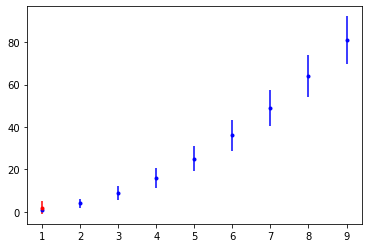

In [112]:
fig, ax = plt.subplots()
x = np.arange(1,10)
y = x **2
error = x**1.1

ax.errorbar(x, y, error, fmt='.b')
ax.errorbar(1,2,3, fmt=".r")

In [36]:
from APT_binary import quadratic_phase_wrap_checker, phase_connector
pint.logging.setup(level = "ERROR")
from pint.fitter import WLSFitter

data_path1 = "/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary6_1"
suffix = data_path1.split("_")[-1]
if socket.gethostname()[0] == "J":
    os.chdir(data_path1)
timfile = f"fake_{suffix}.tim"
parfile = f"fake_{suffix}.par"

m, toas = mb.get_model_and_toas(parfile, timfile)

t = deepcopy(toas)
mjds = t.get_mjds()

t.table["delta_pulse_number"] = np.zeros(len(t))
t.table["clusters"] = t.get_clusters()
 
mask_with_closest = t.table["clusters"] == 0
closest_cluster_mask = t.table["clusters"] == 1
mask_with_closest = np.logical_or(mask_with_closest, closest_cluster_mask)

residuals = pint.residuals.Residuals(t, m).calc_phase_resids()
phase_connector(t, m, "np.unwrap", "all", mjds, mask_with_closest=mask_with_closest, residuals=residuals)

t = deepcopy(t)
t_closest_cluster = deepcopy(t)
t_closest_cluster.select(closest_cluster_mask)
chisq_samples = {}
t_samples = {}
f_samples = {}
b = 10
t = t
f = WLSFitter(t, m)
for wrap in np.arange(-5,6):

    #t_wrapped = deepcopy(t)

    t.table["delta_pulse_number"][closest_cluster_mask] = wrap


    f.fit_toas(maxiter=2)

    # t_wrapped["delta_pulse_number"] = 0
    # t_wrapped.compute_pulse_numbers(f_wrapped.model)

    chisq_samples[wrap] = f.resids.chi2_reduced#pint.residuals.Residuals(
    #     t_wrapped, f_wrapped.model
    # ).chi2_reduced

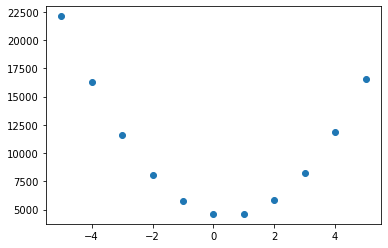

In [37]:
x = chisq_samples.keys()
y = [chisq_samples[key] for key in chisq_samples.keys()]
plt.plot(x,y, "o")

In [85]:
from APT_binary import quadratic_phase_wrap_checker, phase_connector
pint.logging.setup(level = "ERROR")
from pint.fitter import WLSFitter

data_path1 = "/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary6_1"
suffix = data_path1.split("_")[-1]
if socket.gethostname()[0] == "J":
    os.chdir(data_path1)
# timfile = f"fake_{suffix}.tim"
# parfile = f"fake_{suffix}.par"
timfile = "./alg_saves/fake_1/mask0_cluster22/fake_1_prefit2.tim"
parfile = "./alg_saves/fake_1/mask0_cluster22/fake_1_prefit2.par"

m, toas = mb.get_model_and_toas(parfile, timfile)

t = deepcopy(toas)
mjds = t.get_mjds()

t.table["delta_pulse_number"] = np.zeros(len(t))
t.table["clusters"] = t.get_clusters()
 
mask_with_closest = np.logical_or(t.table["clusters"] == 22, t.table["clusters"] == 21)
closest_cluster_mask = t.table["clusters"] == 23
mask_with_closest = np.logical_or(mask_with_closest, closest_cluster_mask)

residuals = pint.residuals.Residuals(t, m).calc_phase_resids()
phase_connector(t, m, "np.unwrap", "all", mjds, mask_with_closest=mask_with_closest, residuals=residuals)

maxiter_while=1
b = 15
iter = 0
f = WLSFitter(t, m)
while True:
    iter += 1
    print(f"iter is {iter} and b is {b}")
    if iter > 10:
        break
    chisq_samples = {}
    try:
        for wrap in range(-b,b+1):#[-b, 0, b]:
            # f = WLSFitter(t, m)
            f.toas.table["delta_pulse_number"][closest_cluster_mask] = wrap
            f.fit_toas(maxiter=maxiter_while)
            chisq_samples[wrap] = f.resids.chi2_reduced
            f.reset_model()
        break
    except Exception as e:
        print(b)
        b -= 1
# raise Exception("test stop")
min_wrap = round(
    (b / 2)
    * (chisq_samples[-b] - chisq_samples[b])
    / (chisq_samples[b] + chisq_samples[-b] - 2 * chisq_samples[0])
)
# check +1, 0, and -1 wrap from min_wrap just to be safe
t_wrap_dict = {}
f_wrap_dict = {}
chisq_wrap = {}
for wrap in range(-1, 2):
    t.table["delta_pulse_number"][closest_cluster_mask] = min_wrap + wrap
    f.fit_toas(maxiter=maxiter_while)

    # t_plus_minus["delta_pulse_number"] = 0
    # t_plus_minus.compute_pulse_numbers(f_plus_minus.model)

    chisq_wrap[f.resids.chi2_reduced] = min_wrap + wrap
    t_wrap_dict[min_wrap + wrap] = deepcopy(t)
    f_wrap_dict[min_wrap + wrap] = deepcopy(f)

min_chisq = min(chisq_wrap.keys())

min_wrap_number_total = chisq_wrap[min_chisq]

t = t_wrap_dict[min_wrap_number_total]
f = f_wrap_dict[min_wrap_number_total]

iter is 1 and b is 15


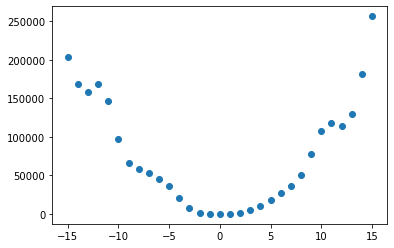

In [86]:
# b = 5 and reassigns fitter everytime
x = chisq_samples.keys()
y = [chisq_samples[key] for key in chisq_samples.keys()]
plt.plot(x,y, "o")

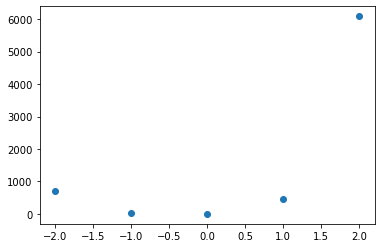

In [34]:
# b = 2 and does not reassign fitter
x = chisq_samples.keys()
y = [chisq_samples[key] for key in chisq_samples.keys()]
plt.plot(x,y, "o")

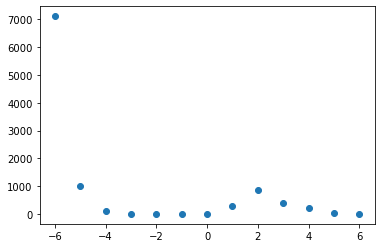

In [51]:
# b = 6 and does not reassign
x = chisq_samples.keys()
y = [chisq_samples[key] for key in chisq_samples.keys()]
plt.plot(x,y, "o")

In [66]:
chisq_samples

{-10: 97116.60972279113615,
 -9: 66533.69775476437161,
 -8: 58437.123909212903946,
 -7: 52773.09525460645581,
 -6: 45561.285545188513776,
 -5: 35695.33915288830228,
 -4: 21044.310862826464373,
 -3: 7834.115297842088613,
 -2: 1522.5586628488047345,
 -1: 81.03778399792218758,
 0: 1.1781461307060778118,
 1: 146.72817823433508964,
 2: 1594.2188078446990382,
 3: 5237.1435868648915246,
 4: 10584.178637789467173,
 5: 18127.217869242178223,
 6: 27347.236834132800022,
 7: 36225.058884537862752,
 8: 50354.34731577010343,
 9: 77976.29759672542055,
 10: 107949.330895907943464}

In [84]:
chisq_wrap

{1522.5586628488047345: -2,
 358.1228269442248919: -1,
 12.7534221194563628975: 0}

In [3]:
# from APT_binary import quadratic_phase_wrap_checker, phase_connector
pint.logging.setup(level = "ERROR")
from pint.fitter import WLSFitter

data_path1 = "/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary6_1"
suffix = data_path1.split("_")[-1]
if socket.gethostname()[0] == "J":
    os.chdir(data_path1)
# timfile = f"fake_{suffix}.tim"
# parfile = f"fake_{suffix}.par"
timfile = "./alg_saves/fake_1/mask0_cluster22/fake_1_prefit2.tim"
parfile = "./alg_saves/fake_1/mask0_cluster22/fake_1_prefit2.par"

m, toas = mb.get_model_and_toas(parfile, timfile)

2022-07-05 10:47:01.908 | DEBUG    | pint.toa:get_TOAs:190 - Using EPHEM = DE421 from the given model
2022-07-05 10:47:01.909 | DEBUG    | pint.toa:get_TOAs:206 - Using CLOCK = BIPM2021 from the given model
2022-07-05 10:47:01.974 | DEBUG    | pint.toa:apply_clock_corrections:2096 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-07-05 10:47:01.986 | DEBUG    | pint.observatory.clock_file:__init__:800 - Global clock file time_gbt.dat saving kwargs={'bogus_last_correction': False}
2022-07-05 10:47:01.988 | DEBUG    | pint.observatory.clock_file:read_tempo_clock_file:608 - Loading TEMPO observatory (None) clock correction file /Users/jackson/.astropy/cache/download/url/599e3ebbfc317e090244ee1ef4c79374/contents with bogus_last_correction=False
2022-07-05 10:47:02.032 | INFO     | pint.observatory.topo_obs:find_clock_file:513 - Using global clock file for time_gbt.dat with bogus_last_correction=False
2022-07-05 10:47:02.033 | INFO     | pint.observatory.topo_obs:c

In [30]:
from loguru import logger as log
pint.logging.setup(level = "WARNING")
log.error("QuadError: stop")
log.warning("test")
print("hi")

ERROR    (__main__                      ): QuadError: stop
WARNING  (__main__                      ): test


hi


In [27]:
b = 5
for i in range(b,-1,-1):
    print(i)
    if i < 3:
        continue
    b = i

5
4
3
2
1
0


In [28]:
b

3

In [69]:
np.zeros((5,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [24]:
#%%
import matplotlib.pyplot as plt
import copy
import numpy as np
import astropy.units as u
import pint.models as pm
import pint.toa as pt
import pint.fitter as pf
import pint.residuals as pr
import pint.simulation as ps
import pint.logging as pl
pl.setup("WARNING")

def make_random_models(fitter, Nmodels=100, params="all"):
    cov_matrix = fitter.parameter_covariance_matrix
    # this is a list of the parameter names in the order they appear in the covariance matrix
    param_names = cov_matrix.get_label_names(axis=0)
    # this is a dictionary with the parameter values, but it might not be in the same order
    # and it leaves out the Offset parameter
    param_values = fitter.model.get_params_dict("free", "value")
    mean_vector = np.array([param_values[x] for x in param_names if x != "Offset"])
    if params == "all":
        # remove the first column and row (absolute phase)
        if param_names[0] == "Offset":
            cov_matrix = cov_matrix.get_label_matrix(param_names[1:])
            fac = fitter.fac[1:]
            param_names = param_names[1:]
        else:
            fac = fitter.fac
    else:
        # only select some parameters
        # need to also select from the fac array and the mean_vector array
        idx, labels = cov_matrix.get_label_slice(params)
        cov_matrix = cov_matrix.get_label_matrix(params)
        index = idx[0].flatten()
        fac = fitter.fac[index]
        # except mean_vector does not have the 'Offset' entry
        # so may need to subtract 1
        if param_names[0] == "Offset":
            mean_vector = mean_vector[index - 1]
        else:
            mean_vector = mean_vector[index]
        param_names = cov_matrix.get_label_names(axis=0)

    f_rand = copy.deepcopy(fitter)
    # scale by fac
    mean_vector = mean_vector * fac
    scaled_cov_matrix = ((cov_matrix.matrix * fac).T * fac).T
    random_models = []
    for _ in range(Nmodels):
        # create a set of randomized parameters based on mean vector and covariance matrix
        # dividing by fac brings us back to real units
        rparams_num = np.random.multivariate_normal(mean_vector, scaled_cov_matrix) / fac
        rparams = dict(zip(param_names, rparams_num))
        f_rand.set_params(rparams)
        random_models.append(f_rand.model)
        f_rand = copy.deepcopy(fitter) # is this necessary?
    return random_models

def compute_random_model_phases(fitter, models, toas, return_time=False):
    Nmodels = len(models)
    Nmjd = len(toas)
    phases_i = np.zeros((Nmodels, Nmjd))
    phases_f = np.zeros((Nmodels, Nmjd))
    for ii, model in enumerate(models):
        phase = model.phase(toas, abs_phase=True)
        # return phase
        # raise Exception("test stop")
        phases_i[ii] = phase.int
        phases_f[ii] = phase.frac
    phases = phases_i + phases_f
    # return phases
    phases0 = fitter.model.phase(toas, abs_phase=True)
    dphase = phases - (phases0.int + phases0.frac)
    if return_time:
        r = pr.Residuals(toas, fitter.model)
        dphase /= r.get_PSR_freq(calctype="taylor")
    return dphase

def compute_random_model_resids(fitter, models, toas, return_time=False):
    resids = np.zeros((len(models), toas.ntoas), dtype=np.float)
    r0 = pr.Residuals(tnew, fitter.model, subtract_mean=False)
    for ii, model in enumerate(models):
        rn = pr.Residuals(tnew, model, subtract_mean=False)
        resids[ii] = rn.time_resids-r0.time_resids if return_time else rn.phase_resids-r0.phase_resids
    return resids << u.s if return_time else resids

m, t = pm.get_model_and_toas("1748-2446Y.par", "Ter5Y.tim", usepickle=True)
# Must do a fit to get parameter covariance matrix
# f = pf.DownhillWLSFitter(t, m)
f = pf.WLSFitter(t, m)
f.fit_toas()

###

import time

# make fake TOAs covering more than the full range
tic = time.perf_counter()
tnew = ps.make_fake_toas_uniform(
    t.get_mjds().min().value - 500,
    t.get_mjds().max().value + 500,
    1000,
    freq=2000.0 * u.MHz,
    model=f.model,
)
toc = time.perf_counter()
print(f"Creating the fake TOAs took {toc-tic:0.4f} sec")

# now make random models
tic = time.perf_counter()
rms = make_random_models(f, 20)
toc = time.perf_counter()
print(f"Making the random models took {toc-tic:0.4f} sec")

tic = time.perf_counter()
phases = compute_random_model_phases(f, rms, tnew, return_time=True)
toc = time.perf_counter()
print(f"Computing the random resids1 took {toc-tic:0.4f} sec")

# tic = time.perf_counter()
# rrs2 = compute_random_model_resids(f, rms, tnew, return_time=True).to(u.us)
# toc = time.perf_counter()
# print(f"Computing the random resids2 took {toc-tic:0.4f} sec")

Creating the fake TOAs took 2.5131 sec
Making the random models took 0.2526 sec
Computing the random resids1 took 4.5808 sec


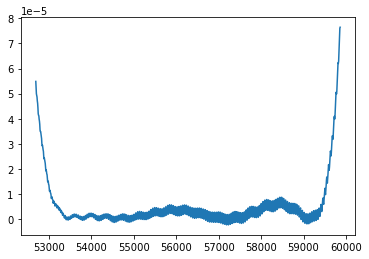

In [25]:
tnew = ps.make_fake_toas_uniform(
    t.get_mjds().min().value - 500,
    t.get_mjds().max().value + 500,
    1000,
    freq=2000.0 * u.MHz,
    model=f.model,
)
mjds = tnew.get_mjds()

plt.plot(mjds,phases[0])

In [41]:
123 * u.s == 123 << u.s

True

In [60]:
tic = time.perf_counter()
dmat, dmat_lab, dmat_units = m.designmatrix(tnew, incfrozen=False, incoffset=False)
toc = time.perf_counter()
print(f"Computing the design matrix took {toc-tic:0.4f} sec")

#%%

tic = time.perf_counter()
fastrs = np.zeros((len(rms), tnew.ntoas), dtype=np.float)
dparam = np.zeros(len(dmat_lab), dtype=np.float128)
for ii, rm in enumerate(rms):
    # Do the differencing
    for jj, pp in enumerate(dmat_lab):
        if type(getattr(m, pp)) == pm.parameter.MJDParameter:
            # print(f"top: {pp}")
            dparam[jj] = (getattr(m, pp).value - getattr(rm, pp).value) * u.d
        else:
            dparam[jj] = getattr(m, pp).quantity - getattr(rm, pp).quantity
            # print(f"bottom: {pp}")
    fastrs[ii] = np.dot(dparam, dmat.T)
fastrs <<= u.s # fastrs = fastrs << u.s
toc = time.perf_counter()
print(f"Computing the random resids via design matrix {toc-tic:0.4f} sec")

Computing the design matrix took 1.9933 sec
Computing the random resids via design matrix 0.0158 sec


In [53]:
f1 = fastrs * u.s
fastrs <<= u.s
f1 == fastrs

False

In [73]:
len(dmat.T)

21

In [77]:
x = np.array([1,2,3])
y = np.array([[1,2,3],[1,2,5], [4,3,5],[3,2,9]])

In [79]:
np.dot(x, y.T)

array([14, 20, 25, 34])

In [94]:
x = np.array([1,2,3])
x <<= u.s
x << u.min
x

<Quantity [1., 2., 3.] s>

In [98]:
%timeit array = np.array([1,2])

464 ns ± 1.73 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [1]:
print("hi"); print("hi"); print("hi")

hi
hi
hi


In [6]:
from pytimedinput import timedInput
import time

t1 = time.monotonic()
result = timedInput("Hello", 5)
t2 = time.monotonic()

print(f"That took {round(t2-t1, 3)} seconds")

RuntimeError: timedInput() requires an interactive shell, cannot continue.

In [2]:
os.chdir("/Users/jackson/Desktop/Pint_Personal/APT/binary_test_data/binary6_1")
pint.logging.setup(level="INFO")


m1, t1 = mb.get_model_and_toas("fake_1sol.par", "fake_1.tim")
t1.compute_pulse_numbers(m1)
pn1 = t1.table["pulse_number"]

m2, t2 = mb.get_model_and_toas("fake_1.fin", "fake_1.tim")
t2.compute_pulse_numbers(m1)
pn2 = t2.table["pulse_number"]

np.array_equal(pn1, pn2)


INFO     (pint.observatory.topo_obs     ): Using global clock file for time_gbt.dat with bogus_last_correction=False
INFO     (pint.observatory.topo_obs     ): Applying observatory clock corrections.
INFO     (pint.observatory.topo_obs     ): Applying GPS to UTC clock correction (~few nanoseconds)
INFO     (pint.observatory.topo_obs     ): Loading global GPS clock file for gbt
INFO     (pint.observatory.topo_obs     ): Using global clock file for gps2utc.clk with bogus_last_correction=False
INFO     (pint.observatory.topo_obs     ): Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
INFO     (pint.observatory.topo_obs     ): Loading BIPM clock version bipm2021 for gbt
INFO     (pint.observatory.topo_obs     ): Using global clock file for tai2tt_bipm2021.clk with bogus_last_correction=False
WARNING  (pint.toa                      ): No ephemeris provided to TOAs object or compute_TDBs. Using DE421
INFO     (pint.solar_system_ephemerides ): Set solar system ephemeris to de421 fro

True

In [8]:
start = "1".split(",")
x= [int(i) for i in start]
x

[1]

In [16]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
print(f"{bcolors.OKBLUE}Warning: No active frommets remain. Continue?{bcolors.UNDERLINE}")



